In [63]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from scipy.sparse import csr_matrix
from src.scoring import *
import matplotlib.pyplot as plt
%matplotlib inlineAQ
plt.style.use('fivethirtyeight')

In [7]:
df = pd.read_csv('data/Task2inputs.csv')
y = df.pop('fraud')
df.head()

,amount,hour1,state1,zip1,custAttr1,custAttr2,field2,hour2,flag1,field3,...,flag5,field3_scld,field4_sqd,field4_log,zip_log,amount_root,field1__1,field1__2,field1__3,field1__4
0,12.95,0,WA,986,1234567890123456,luhxsodzmjhng7@comcast.net,0,0,0,-723,...,1,0.745739,361,2.944439,6.893656,3.598611,0,0,0,0
1,38.85,0,WA,980,1234567890123457,pfixyiqfpvkcg@zjyxs.net,1,0,0,5497,...,1,0.923596,196,2.639057,6.887553,6.232977,0,0,1,0
2,38.85,0,KY,402,1234567890123458,shbjoldciswwm@aol.com,1,0,0,-4420,...,1,0.640026,529,3.135494,5.996452,6.232977,0,1,0,0
3,12.95,0,CA,958,1234567890123459,ipbvtdfkhhfws@sbcglobal.net,0,0,0,5010,...,1,0.909671,961,3.433987,6.864848,3.598611,0,0,1,0
4,38.85,0,GA,300,1234567890123460,ivfuvxiennhdp@bellsouth.net,1,0,0,-4074,...,1,0.649920,441,3.044522,5.703782,6.232977,0,0,1,0


In [39]:
df

,amount,hour1,zip1,custAttr1,field2,flag1,field3,field4,indicator1,indicator2,flag2,flag3,flag4,flag5,field1__1,field1__2,field1__3,field1__4
0,12.95,0,986,1234567890123456,0,0,-723,19,0,0,0,0,0,1,0,0,0,0
1,38.85,0,980,1234567890123457,1,0,5497,14,1,0,0,1,0,1,0,0,1,0
2,38.85,0,402,1234567890123458,1,0,-4420,23,0,0,1,1,0,1,0,1,0,0
3,12.95,0,958,1234567890123459,0,0,5010,31,0,0,1,0,0,1,0,0,1,0
4,38.85,0,300,1234567890123460,1,0,-4074,21,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,31.08,14,313,1234567890197181,0,1,-8044,10,0,0,0,0,0,1,0,1,0,0
99995,49.95,14,704,1234567890197182,0,0,393,18,1,0,1,0,0,1,0,0,0,0
99996,11.01,14,117,1234567890196488,1,1,4261,11,0,0,1,1,0,1,0,0,1,0
99997,12.95,14,245,1234567890197183,1,0,515,21,0,0,0,0,0,1,0,0,1,0


In [32]:
df = df[['amount', 'hour1', 'zip1', 'custAttr1', 'field2', 'flag1', 'field3', 'field4', 'indicator1', 'indicator2',
       'flag2', 'flag3', 'flag4', 'flag5', 'field1__1', 'field1__2','field1__3', 'field1__4']]

In [40]:
def get_sparse_matrix(df, columns):
    out = df.copy()
    for col in columns:
        dummies = pd.get_dummies(df[col], prefix=col)
        out = pd.concat([out.drop(columns=col), dummies.iloc[:,1:]], axis=1)
        print ('done')
    return csr_matrix(out)

In [41]:
X = get_sparse_matrix(df, ['amount','hour1','zip1','custAttr1','field3','field4','flag5'])

done
done
done
done
done
done
done


In [46]:
X

<99999x91744 sparse matrix of type '<class 'numpy.int64'>'
	with 970828 stored elements in Compressed Sparse Row format>

In [53]:
X_main, X_holdout, y_main, y_holdout = train_test_split(X, np.asarray(y), random_state=7, test_size=.35,stratify=y)

In [54]:
y_main.sum()

1725.0

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_main, y_main, random_state=7, test_size=.35,stratify=y_main)

In [29]:
xgb = XGBClassifier(booster='dart', colsample_bylevel=1,
                    colsample_bynode=1, colsample_bytree=1, gamma=0,
                    learning_rate=0.05, max_delta_step=0, max_depth=3,
                    min_child_weight=1, n_estimators=300, n_jobs=-1, base_score=.5,
                    random_state=2, reg_alpha=0, reg_lambda=1, scale_pos_weight=30)

In [61]:
xgb1 = XGBClassifier()
cv_ = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(xgb1, X_train, y_train, scoring='roc_auc', cv=cv_, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.822


In [66]:
xgb1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Training Data | Voting Classifier
  TP  |  FN  |  FP  |  TN  
--------------------------
   151|   346|  1226| 16894
--------------------------
Recall:     0.3038
Precision:  0.1097
ROC_AUC:    0.6181

Testing  Data | Voting Classifier
  TP  |  FN  |  FP  |  TN  
--------------------------
    22|   191|   570|  7196
--------------------------
Recall:     0.1033
Precision:  0.0372
ROC_AUC:    0.5149


#### TUNING MAX DEPTH

In [80]:
max_depths = np.linspace(1, 20, 10, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    xgb = XGBClassifier(max_depth=int(max_depth))
    xgb.fit(X_train, y_train)
    train_pred = xgb.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = xgb.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

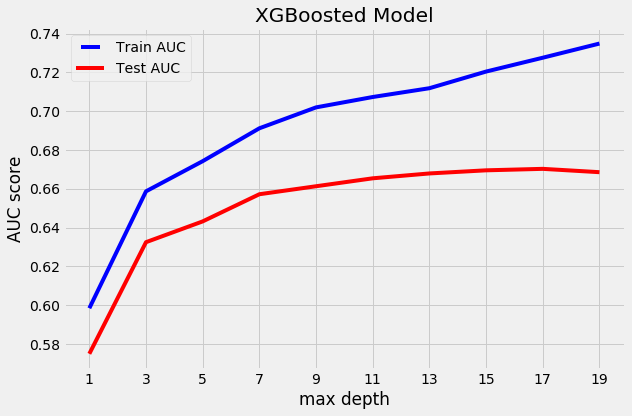

In [92]:
from matplotlib.legend_handler import HandlerLine2D
fig, ax = plt.subplots(figsize=(9, 6))
line1, = ax.plot(np.arange(1, 21, 2), train_results, 'b', label='Train AUC')
line2, = ax.plot(np.arange(1, 21, 2), test_results, 'r', label='Test AUC')
ax.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
ax.set_title('XGBoosted Model')
ax.set_xticks(np.arange(1, 21, 2))
ax.set_ylabel('AUC score')
ax.set_xlabel('max depth')
fig.tight_layout()
plt.savefig('visuals/XGBdepths.png')

#### TUNING WEIGHT

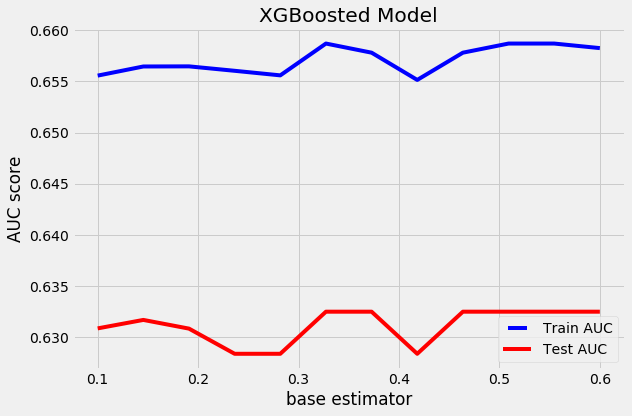

In [93]:
weights = np.linspace(.1, .6, 12, endpoint=True)
train_results = []
test_results = []
for weight in weights:
    xgb = XGBClassifier(base_score=weight)
    xgb.fit(X_train, y_train)
    train_pred = xgb.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = xgb.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
fig, ax = plt.subplots(figsize=(9, 6))
line1, = ax.plot(weights, train_results, 'b', label='Train AUC')
line2, = ax.plot(weights, test_results, 'r', label='Test AUC')
ax.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
ax.set_title('XGBoosted Model')
ax.set_ylabel('AUC score')
ax.set_xlabel('base estimator')
fig.tight_layout()
plt.savefig('visuals/XGBestimator.png')

#### TUNING

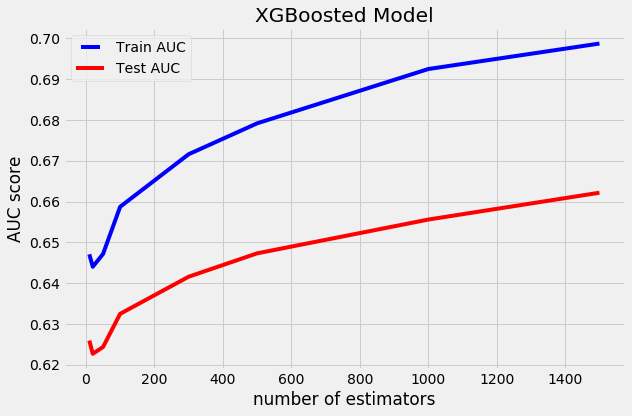

In [96]:
trees = [10, 20, 50, 100, 300, 500, 1000, 1500]
train_results = []
test_results = []
for tree in trees:
    xgb = XGBClassifier(n_estimators=tree)
    xgb.fit(X_train, y_train)
    train_pred = xgb.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = xgb.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
fig, ax = plt.subplots(figsize=(9, 6))
line1, = ax.plot([tree for tree in trees], train_results, 'b', label='Train AUC')
line2, = ax.plot([tree for tree in trees], test_results, 'r', label='Test AUC')
ax.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
ax.set_title('XGBoosted Model')
ax.set_ylabel('AUC score')
ax.set_xlabel('number of estimators')
fig.tight_layout()
plt.savefig('visuals/XGBntrees.png')

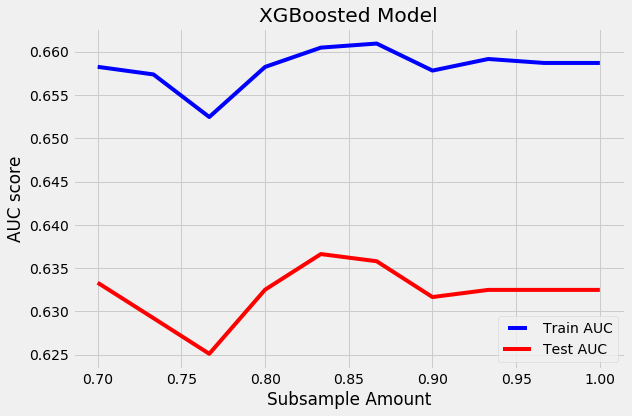

In [97]:
regs = np.linspace(.7, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for reg in regs:
    xgb = XGBClassifier(subsample=reg, n_estimators=100, max_depth=3, n_jobs=-1)
    xgb.fit(X_train, y_train)
    train_pred = xgb.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = xgb.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
fig, ax = plt.subplots(figsize=(9, 6))
line1, = ax.plot(regs, train_results, 'b', label='Train AUC')
line2, = ax.plot(regs, test_results, 'r', label='Test AUC')
ax.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
ax.set_title('XGBoosted Model')
ax.set_ylabel('AUC score')
ax.set_xlabel('Subsample Amount')
fig.tight_layout()
plt.savefig('visuals/SubsampleXGB.png')

In [103]:
xgb2 = XGBClassifier(booster='dart', subsample=.8,
                    learning_rate=0.05, max_delta_step=0, max_depth=8,
                    min_child_weight=1, n_estimators=1500, n_jobs=-1)

In [100]:
cv_ = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(xgb2, X_train, y_train, scoring='roc_auc', cv=cv_, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.821


In [104]:
xgb2.fit(X_main, y_main)

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=1500, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [ ]:
print ('Training Data | Fully-Tuned')
print_results(X_train, y_train, xgb2)
print ('')
print ('Testing  Data | Fully-Tuned')
print_results(X_holdout, y_holdout, xgb2)

In [152]:
booster = xgb.fit(X_train, y_train, eval_metric='auc')

In [186]:
print ('Training Data | Fully-Tuned')
print_results(X_train, y_train, booster, .08)
print ('')
print ('Testing  Data | Fully-Tuned')
print_results(X_test, y_test, booster, p=False)

Training Data | Fully-Tuned
  TP  |  FN  |  FP  |  TN  
--------------------------
   206|  1652|   939| 67202
--------------------------
Recall:     0.1109
Precision:  0.1799
ROC_AUC:    0.5485

Testing  Data | Fully-Tuned
  TP  |  FN  |  FP  |  TN  
--------------------------
     5|   791|     6| 29198
--------------------------
Recall:     0.006281
Precision:  0.4545
ROC_AUC:    0.5030


In [160]:
thresholds = np.linspace(.015, .045, 50)
scores = []
for thresh in thresholds:
    ROC = metrics.roc_auc_score(y_test, predict(booster, X_test, thresh))
    scores.append(ROC)

Text(0.5, 1.0, 'My Best Model :/')

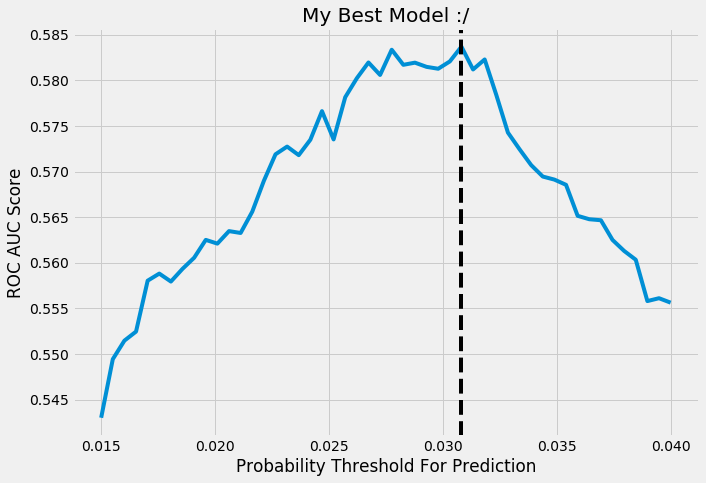

In [165]:
fig, ax = plt.subplots(figsize=(10, 7))
best_score = np.argmax(np.array(scores))
ax.axvline(thresholds[best_score], color='k', linestyle='--')

ax.plot(thresholds, scores)
ax.set_ylabel('ROC AUC Score')
ax.set_xlabel('Probability Threshold For Prediction')
ax.set_title('My Best Model :/')

In [163]:
thresholds[best_score]

0.030816326530612247

In [190]:
probas = booster.predict_proba(X_test)

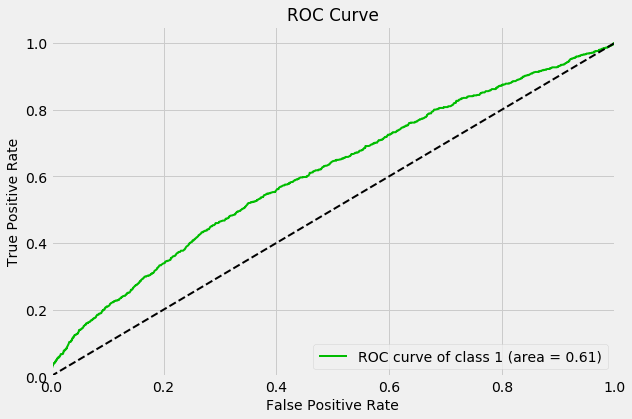

<Figure size 432x288 with 0 Axes>

In [197]:
skplt.metrics.plot_roc(y_test, probas, title='ROC Curve', plot_macro=False, plot_micro=False, figsize=(9, 6), classes_to_plot=[1])
plt.show()
plt.savefig('visuals/ROC.png')

In [105]:
from sklearn.metrics import plot_roc_curve

TypeError: 'Text' object is not callable

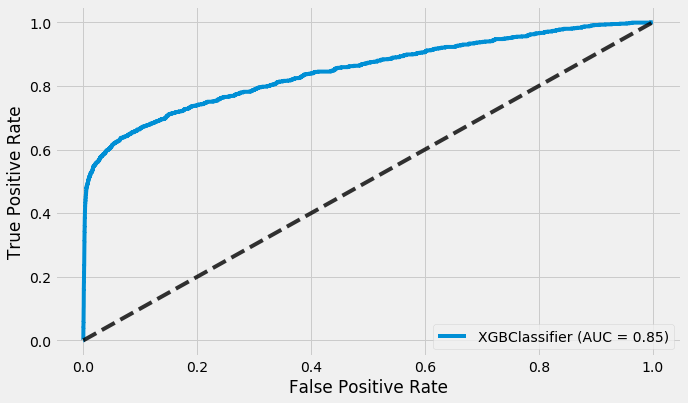

In [107]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_roc_curve(xgb2, X_holdout, y_holdout, ax=ax)
#plot_roc_curve(xgb, X_holdout, y_holdout, ax=ax)
ax.plot(np.linspace(0,1), np.linspace(0,1), color='k', linestyle='--', alpha=.8)
ax.title('ROC')